### Neurophysiology and Biophysics - Practical course WS 2024/25
__Cornelia Kopp-Scheinpflug & Kay Thurley__

# Miniproject: Gap junctions and network synchorization

In this notebook we simulate a small network of electrically coupled Drosophila motoneurons. The network shows different regimes of synchrony depending on the coupling strength of the GAP junctions, which is supposed to underly the insect's flight. The model was used in Hürkey et al. (2023) and adapted by Kay Thurley (2024).


_Requirements:_ You will need Python 3 and the packages Numpy, Matplotlib and BRIAN2.


We start by importing the relevant packages.

In [1]:
import numpy as np
from brian2 import *
import sys, os
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import json

from utils.brianutils import units
from utils.random_initial_conditions import *
from utils.sim import *
from utils.convert_ggap_ccs import *
from utils.spiketime_analysis_helper import *

saving/loading sims from:  sim_results/


Then we define load some parameters and define the neuron.

In [2]:
md_SNL = json.load(open("cfg/Berger_SNL.json"))
md_SNIC = json.load(open("cfg/Berger_SNIC.json"))
ggap_hom = np.load('cfg/ggap_hom.npy')*nS
ggap_het = np.load('cfg/ggap_het.npy')*nS

In [3]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
np.random.seed(42)
g_gap = ggap_het
# g_gap = .15*nS
dur = 50*second
solver = 'heun'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 
noise_stdev = 1e-8
fname='SNL_weakcoupling_nonoise'

φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
# φs_chosen = np.array([0.5, 0.6, 0.9, 0.7, 0.8])
initial_values = pick_initial_phase_SNL(φs_chosen)
StM1, SpM1 = run_sim(N, md_SNL, g_gap, None, initial_values=initial_values,
                     dur=dur, σnoise=noise_stdev, solver=solver, dt=dt)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value array([[ 0.        , 86.58631126, 38.26934378, 38.26934378, 27.1874998 ],
       [86.58631126,  0.        , 38.26934378, 38.26934378, 27.1874998 ],
       [38.26934378, 38.26934378,  0.        , 86.58631126, 27.1874998 ],
       [38.26934378, 38.26934378, 86.58631126,  0.        , 27.1874998 ],
    

Starting simulation at t=0. s for a duration of 50. s
3.6583 s (7%) simulated in 10s, estimated 2m 7s remaining.
7.44 s (14%) simulated in 20s, estimated 1m 54s remaining.
11.1874 s (22%) simulated in 30s, estimated 1m 44s remaining.
14.9351 s (29%) simulated in 40s, estimated 1m 34s remaining.
18.7414 s (37%) simulated in 50s, estimated 1m 23s remaining.
22.4511 s (44%) simulated in 1m 0s, estimated 1m 14s remaining.
26.1811 s (52%) simulated in 1m 10s, estimated 1m 4s remaining.
29.8669 s (59%) simulated in 1m 20s, estimated 54s remaining.
33.6343 s (67%) simulated in 1m 30s, estimated 44s remaining.
37.3311 s (74%) simulated in 1m 40s, estimated 34s remaining.
41.0538 s (82%) simulated in 1m 50s, estimated 24s remaining.
44.6402 s (89%) simulated in 2m 0s, estimated 14s remaining.
48.2474 s (96%) simulated in 2m 10s, estimated 5s remaining.
50. s (100%) simulated in 2m 14s


Text(0.97, 0.184, '[mV]')

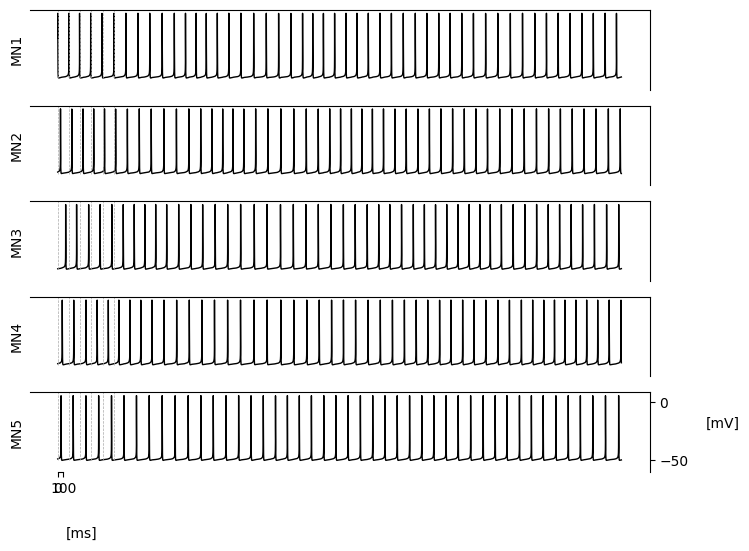

In [5]:
fig, ax = plt.subplots(5, 1, figsize=(8, 6))

ts=StM1.t_
per=np.median(np.diff(SpM1.t_[SpM1.i==0]))*second
t_unit=ms
N=5

tstart = SpM1.t_[SpM1.i==0][SpM1.t_[SpM1.i==0]>2].min()
m=(ts>tstart) & (ts<tstart+10)
for i in range(N):
    ax[i].plot(StM1.t[m]/ms-tstart*1000, StM1.v[i][m]/mV, c='k',lw=1)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_ylabel('MN{}'.format(i+1))
    ax[i].set_yticks([])
    ax[i].set_ylim(-60,)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_xticks([])
    # shift = 2000
    # ax[i].set_xlim(0 + shift,300 + shift)

    for k in range(0,6):
        ax[i].plot([k*per/t_unit,k*per/t_unit],[-50,10],'--',lw=0.5,c='darkgrey')


ax[-1].set_xticks([0,100])
ax[-1].spines['bottom'].set_bounds(0,100)
ax[-1].spines['bottom'].set_visible(True)
fig.text(0.17,0.0,'[ms]')

ax[-1].spines['right'].set_visible(True)
ax[-1].yaxis.tick_right()
ax[-1].set_yticks([-50,0])
fig.text(0.97,0.184,'[mV]')

In [19]:
class PseudoSpikeMonitor:
    def __init__(self, i, t):
        self.i = i
        self.t = t

mask = SpM1.i != 4
SpM1_filtered = PseudoSpikeMonitor(SpM1.i[mask], SpM1.t[mask])


0.0639 49.81679999999999
497529


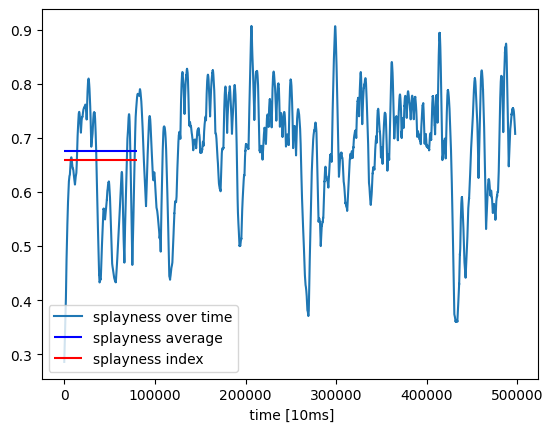

In [21]:
from utils.spiketime_analysis_helper import *
# Splayness index
# Make sure tstart tend and dt have same units 
mask = SpM1.i != 4  # boolean mask that excludes neuron 4
tmin, tmax = get_tminmax(SpM1)
print(tmin, tmax)
print(len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.hlines(np.mean(get_splayness(SpM1, tmin, tmax, 100e-6)[0]),0, 80000, color='b', label = 'splayness average')
plt.hlines(get_splayness(SpM1, tmin, tmax, 100e-6)[1],0, 80000, color='r', label = 'splayness index')
plt.xlabel(' time [10ms]')
plt.legend()
plt.show()

In [22]:
from collections import defaultdict

def extract_splay_sequences_ignored(spike_ids, spike_times, N=5, ignore_id=4):
    """
    Extract repeating splay sequences, ignoring spikes from a given neuron ID.

    Parameters
    ----------
    spike_ids : array-like
        Neuron IDs for each spike event (e.g., SpM.i)
    spike_times : array-like
        Corresponding spike times (e.g., SpM.t)
    N : int
        Total neuron count (used for pattern length)
    ignore_id : int
        Neuron ID to ignore (e.g., 4)

    Returns
    -------
    pattern_times : dict
        {pattern_string: [list of start times]}
    """

    # Filter out ignored neuron spikes
    valid_mask = spike_ids != ignore_id
    spike_ids = spike_ids[valid_mask]
    spike_times = spike_times[valid_mask]

    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    # each pattern is now N-1 neurons long
    pattern_len = N - 1

    for idx in zero_spike_indices:
        if idx + pattern_len <= len(spike_ids):
            pattern = ''.join(str(x+1) for x in spike_ids[idx:idx + pattern_len])
            t = spike_times[idx]  # start time
            pattern_times[pattern].append(t)

    return pattern_times

def extract_splay_sequences(spike_ids, spike_times, N=5):
    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    for idx in zero_spike_indices:
        # make sure there are at least N spikes after this 0
        if idx + N <= len(spike_ids):
            pattern = ''.join(str(x+1) for x in spike_ids[idx:idx + N])
            t = spike_times[idx]  # time of this pattern’s start (neuron 0 spike)
            pattern_times[pattern].append(t)

    return pattern_times

defaultdict(<class 'list'>, {'1423': [15.7 * msecond, 7.743 * second, 7.9451 * second, 8.1561 * second, 8.3694 * second, 8.5751 * second, 8.7853 * second, 8.987 * second, 9.1938 * second, 9.4006 * second, 9.617 * second, 9.833 * second, 28.4678 * second, 28.6675 * second, 28.8632 * second, 29.0737 * second, 29.274 * second, 29.4688 * second, 29.6622 * second, 29.8551 * second, 30.0531 * second, 30.2512 * second, 30.4569 * second, 30.6644 * second, 30.873 * second, 31.0809 * second, 31.2772 * second, 31.4658 * second, 31.6494 * second, 31.8358 * second, 32.0351 * second, 32.2366 * second, 32.4414 * second, 32.6343 * second, 32.8228 * second, 33.0139 * second, 33.2 * second, 33.3997 * second, 33.6066 * second, 33.8105 * second, 34.0196 * second, 34.2238 * second, 34.4162 * second, 34.6037 * second, 34.7914 * second, 34.9832 * second, 35.1843 * second, 35.3844 * second, 35.5745 * second, 35.7693 * second, 35.9564 * second, 36.1593 * second, 36.3519 * second, 36.5561 * second, 36.7612 * se

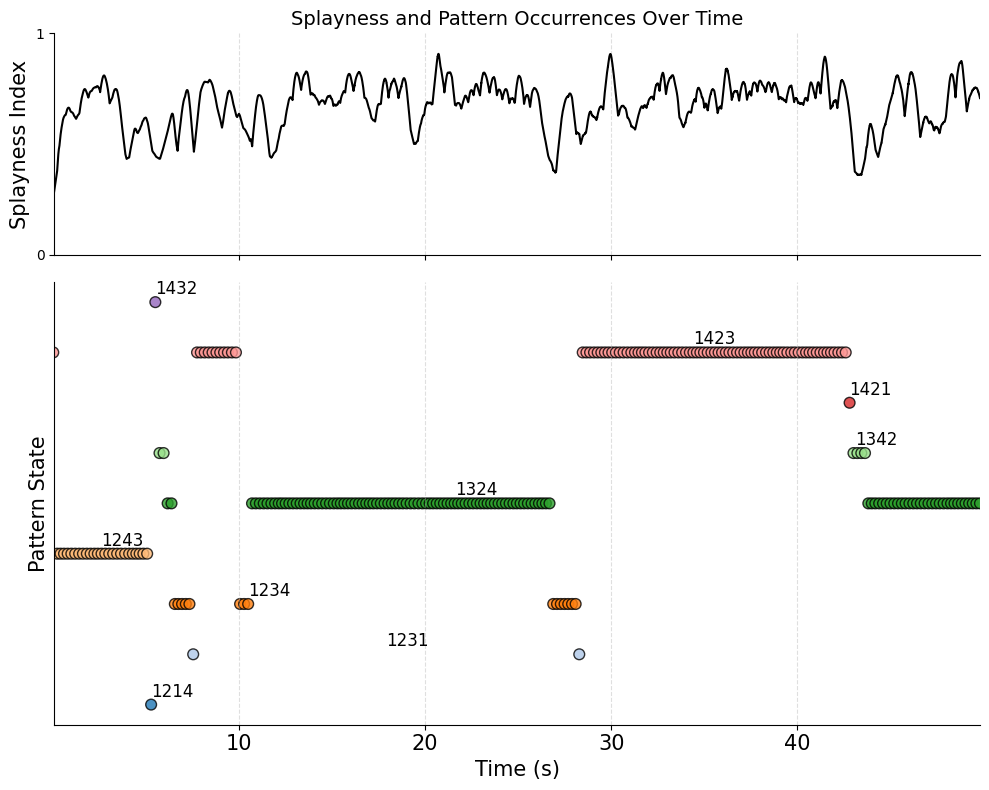

In [23]:
# assuming patterns_times = extract_splay_sequences_ignored(SpM1.i, SpM1.t, N=5)
patterns_times = extract_splay_sequences_ignored(SpM1.i, SpM1.t, N=5)
print(patterns_times)

# Get unique patterns
all_patterns = sorted(patterns_times.keys())
n_patterns = len(all_patterns)

# map patterns to normalized y positions (0–1)
pattern_to_y = {p: i / (n_patterns - 1) if n_patterns > 1 else 0.5 for i, p in enumerate(all_patterns)}

x, y, colors = [], [], []
cmap = plt.get_cmap('tab20')

for i, pattern in enumerate(all_patterns):
    times = patterns_times[pattern]
    x.extend(times)
    y.extend([pattern_to_y[pattern]] * len(times))
    colors.extend([cmap(i % 20)] * len(times))
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2]})

# ---------- Top subplot: splayness ----------
splay_values, _ = get_splayness(SpM1, tmin, tmax, 100e-6)
times = np.linspace(tmin, tmax, len(splay_values))
axs[0].plot(times, splay_values, color='black', lw=1.5)
axs[0].set_ylabel("Splayness Index", fontsize=15)
axs[0].set_title("Splayness and Pattern Occurrences Over Time", fontsize=14)
axs[0].grid(axis='x', linestyle='--', alpha=0.4)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylim(0,1)
axs[0].set_yticks([0,1]) 
# large xticks font large 

# axs[0].set_xticks(np.arange(tmin, tmax, step=1*second))


# ---------- Bottom subplot: pattern occurrences ----------
axs[1].scatter(x, y, c=colors, s=60, edgecolor='k', alpha=0.8)

# add text labels near their median positions
for i, pattern in enumerate(all_patterns):
    times = np.array(patterns_times[pattern])
    if len(times) > 0:
        x_pos = np.median(times)
        y_pos = pattern_to_y[pattern]
        axs[1].text(x_pos, y_pos + 0.02, pattern, fontsize=12, ha='left', color='k')

axs[1].set_xlabel("Time (s)", fontsize=15)
axs[1].set_ylabel("Pattern State", fontsize=15)
axs[1].set_xlim(tmin, tmax)
axs[1].set_ylim(-0.05, 1.05)
axs[1].grid(axis='x', linestyle='--', alpha=0.4)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=15)
plt.tight_layout()
plt.show()




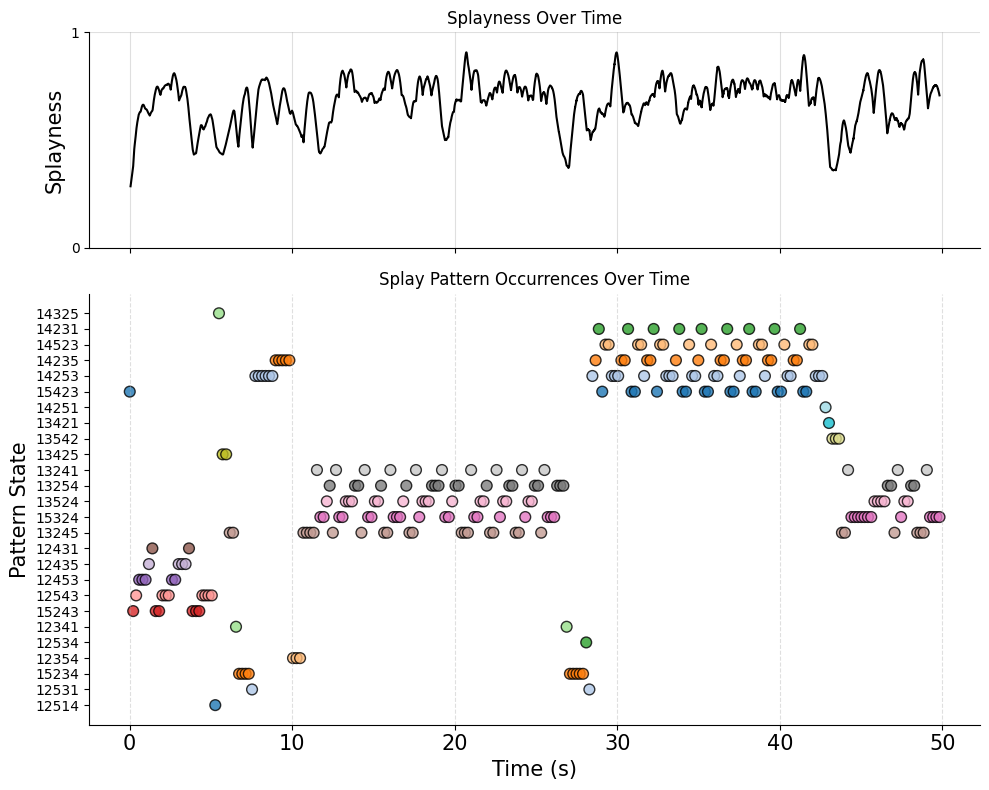

In [48]:
# --- Extract and sort patterns ignoring '5' for ordering ---
patterns_times = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

def pattern_key(p):
    return ''.join([ch for ch in p if ch != '5'])

all_patterns = sorted(patterns_times.keys(), key=pattern_key)
pattern_to_y = {p: i for i, p in enumerate(all_patterns)}

# --- Prepare scatter data ---
x, y, colors, texts = [], [], [], []
cmap = plt.get_cmap('tab20')

for i, pattern in enumerate(all_patterns):
    times = patterns_times[pattern]
    x.extend(times)
    y.extend([pattern_to_y[pattern]] * len(times))
    colors.extend([cmap(i % 20)] * len(times))
    texts.extend([pattern.replace('5', '')] * len(times))  # text version without '5'

# --- Compute splayness ---
splay_vals, _ = get_splayness(SpM1, tmin, tmax, 100e-6)
times = np.linspace(tmin, tmax, len(splay_vals))

# --- Plot ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2]})

# --- Top: Splayness over time ---
axs[0].plot(times, splay_values, color='black', lw=1.5)
axs[0].set_ylabel("Splayness", fontsize=15)
axs[0].set_title("Splayness Over Time")
axs[0].grid(alpha=0.4)
# axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylim(0, 1)
axs[0].set_yticks([0,1])


# --- Bottom: Pattern occurrences ---
sc = axs[1].scatter(x, y, c=colors, s=60, edgecolor='k', alpha=0.8)
axs[1].set_yticks(range(len(all_patterns)))
axs[1].set_yticklabels(all_patterns)
axs[1].set_xlabel("Time (s)", fontsize=15)
axs[1].set_ylabel("Pattern State", fontsize=15)
axs[1].set_title("Splay Pattern Occurrences Over Time")
axs[1].grid(axis='x', linestyle='--', alpha=0.4)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].tick_params(axis='x', labelsize=15)

# --- Add pattern text labels ---
# for xi, yi, txt in zip(x, y, texts):
#     axs[1].text(xi + 0.001, yi, txt, fontsize=8, alpha=0.7, va='center')  # small offset

plt.tight_layout()
plt.show()


In [9]:
patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)
# Get unique patterns and assign each a y-value
all_patterns = sorted(patterns_times.keys())
pattern_to_y = {p: i for i, p in enumerate(all_patterns)}

# for p, times in patterns.items():
#     print(f"Pattern {p} occurred {len(times)} times at times {np.round(times,3)}")


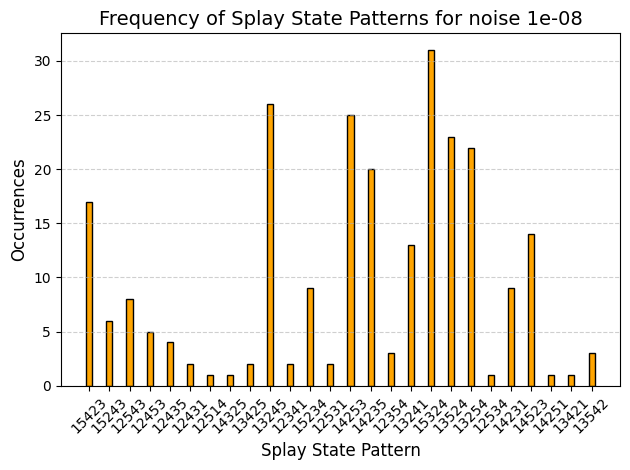

In [10]:
# Assuming you've already run:
# patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

# Extract data for plotting
pattern_names = list(patterns.keys())
occurrences = [len(times) for times in patterns.values()]

# # Sort by most frequent pattern (optional, for clarity)
# sorted_idx = np.argsort(occurrences)[::-1]
# pattern_names = [pattern_names[i] for i in sorted_idx]
# occurrences = [occurrences[i] for i in sorted_idx]

# Plot
plt.figure()
plt.bar(pattern_names, occurrences, color='orange', edgecolor='black', width=0.3)
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.title(f'Frequency of Splay State Patterns for noise {noise_stdev}', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
